# Deep Drone 

In [15]:
%tensorflow_version 1.14  # this line is required for a notebook
import tensorflow as tf
import pandas as pd
import numpy as np
from IPython.display import HTML
from matplotlib import pyplot as plt 

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14  # this line is required for a notebook`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


# Intoduction 
Airsim	is	a	simulator	for	drones,	cars	and	more,	built	on	Unreal	Engine.	It	is	opensource,	cross	platform,	and	supports	hardware-in-loop	with	popular	flight	controllers	such	
as	PX4	for	physically	and	visually	realistic	simulations.	It	is	developed	as	an	Unreal	
plugin	that	can	simply	be	dropped	into	any	Unreal	environment.	Airsim's	goal	is	to	
develop	AirSim	as	a	platform	for	AI	research	to	experiment	with	deep	learning,	computer	
vision	and	reinforcement	learning	algorithms	for	autonomous	vehicles.	For	this	purpose,	
AirSim	also	exposes	APIs	to	retrieve	data	and	control	vehicles	in	a	platform	independent	
way.	




In [16]:


HTML('<iframe width="1250" height="703" src="https://www.youtube.com/embed/8g3Wo9dBc7I" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

#The	Challenge

We	want	to	fly	a	drone	autonomously	and	without	GPS.	for	that	we	made	a	diffrent
algorithm's	such	as	fly	close	to	one	wall	;	fly	close	to	two	walls	,	hover	,	emergency
break	;	and	more	,	the	ML	part	is	to	choose	the	right	algorithm	for	the	current	situation.
that	is	a	classification	problem	to	classify	the	wanted	state	based	on	the	lidars	data.

# The Data

The	data	is	a	log	file	from	the	drone	that	contains	the	drone	telemetry	and	the	lidars
(ranges	to	different	directions	)	and	the	wanted	state	that	human	choose	by	vision	for
the	current	situation.
The	Data example	:
notice	that	the	most	right	column	is	the	one	we	want	to	predict.

# Show how the data was created.
![alt text](https://github.com/simon-pikalov/deep_drone/blob/main/photo/data_gen.png?raw=true)

# Data sample

![alt text](https://github.com/simon-pikalov/deep_drone/blob/main/photo/data_vis.png?raw=true)



# Load the data


In [17]:
!wget https://raw.githubusercontent.com/simon-pikalov/deep_drone/main/comb.csv # download the csv data 

--2020-12-17 10:56:42--  https://raw.githubusercontent.com/simon-pikalov/deep_drone/main/comb.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1481669 (1.4M) [text/plain]
Saving to: ‘comb.csv.2’

comb.csv.2          100%[===================>]   1.41M  --.-KB/s    in 0.04s   

2020-12-17 10:56:42 (33.3 MB/s) - ‘comb.csv.2’ saved [1481669/1481669]



# Helping functions 

In [18]:
def split_train_test(data, div=0.8):
    xdim = data.shape[0]
    split = int(xdim * div)
    train = data[:split]
    test = data[split:]
    return train, test


def show_progress(i):
    loss = cross_entropy.eval(session=sess, feed_dict={x: train_data, y_: train_states})
    print('Iteration:', i, ' loss:',loss)

#Softmax with no hidden layers, for compression

            VX        VY  ...  Range_Left             State
5268  0.315260 -0.054090  ...    8.378806      State.normal
5373  0.301282 -0.104406  ...   10.431355      State.normal
5780  0.373248  0.041287  ...    7.404158      State.normal
301  -0.053551  0.015319  ...   13.261593      State.normal
4104  0.303904 -0.068949  ...    9.751291      State.normal
...        ...       ...  ...         ...               ...
3688  0.477938  0.021574  ...    1.406926   State.emergency
3390  0.737682 -0.345988  ...    0.298726   State.emergency
4259  0.535319  0.038306  ...    3.107553      State.normal
6153  0.332384  0.200120  ...    2.926423        State.safe
1615  0.314070 -0.009077  ...   -1.000000      State.normal

[6326 rows x 6 columns]
Iteration: 0  loss: 1.0878245
Iteration: 100  loss: 0.8072341
Iteration: 200  loss: 0.78229976
Iteration: 300  loss: 0.7724892
Iteration: 400  loss: 0.7667595
Iteration: 500  loss: 0.76280713
Iteration: 600  loss: 0.759768
Iteration: 700  loss: 0.75724965

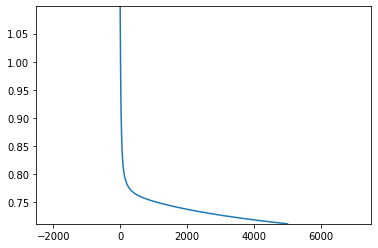

In [19]:

file_name = "comb.csv"
loss_list =[]

all_data_list = ["VX", "VY", "Range_Front","Range_Right","Range_Left","State"]  # define columns to read  from csv TODO add left
feature_list = ["VX", "VY", "Range_Front", "Range_Right", "Range_Left"]
predict_list = ["State"]

df_data = pd.read_csv(file_name, usecols=all_data_list)  # read the collums from the defind col_list
df_data = df_data.sample(frac=1) # random the rows
one_hot_state = pd.get_dummies(df_data["State"])  # transform the data to be predicted to one hot
state = one_hot_state.to_numpy()  # make a numpy array of states
feature = df_data[feature_list]



print(df_data)

(train_data, test_data) = split_train_test(feature)
(train_states,test_states) = split_train_test(state)

# front_arr = np.array([front]) if i wont ro predict by one line only need to convert it to a 2d array

labels_amount =  len(state[0]) # the amount of labels , to be predicted
features_amount = len(feature_list) # The amount of data that the prediction is going to be made on (raw data)
learing_rate = 0.0009

#learing_rate = 0.00005


x = tf.placeholder(tf.float32, (None, features_amount))
y_ = tf.placeholder(tf.float32, (None, labels_amount))
W = tf.Variable(tf.zeros((features_amount, labels_amount)))
b = tf.Variable(tf.zeros((labels_amount)))  # TODO change it to tf.random.uniform
y = tf.nn.softmax(tf.matmul(x, W) + b)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=x)) #TODO try this

train_step = tf.train.GradientDescentOptimizer(learing_rate).minimize(cross_entropy)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


# good values itr = 100000 ,learing_rate = 0.0009


for i in range(5000):
    loss = cross_entropy.eval(session=sess, feed_dict={x: train_data, y_: train_states})
    sess.run(train_step, feed_dict={x: train_data, y_: train_states})  # BGD
    loss_list.append(loss)
    if i %100 ==0 :
        show_progress(i)


correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: test_data, y_: test_states}))


plt.margins(x=0.5, y=0.0)   # Values in (-0.5, 0.0) zooms in to center
x_axis = np.arange(0, len(loss_list),1)
plt.plot(x_axis, loss_list)
plt.show()




# NN with softmax and Adam Optimizer

[[0 1 0]
 [0 1 0]
 [0 1 0]
 ...
 [0 1 0]
 [0 0 1]
 [0 1 0]]
Iteration: 0  loss: 1.1185554
Iteration: 100  loss: 1.0716476
Iteration: 200  loss: 1.0226096
Iteration: 300  loss: 0.9710792
Iteration: 400  loss: 0.92003304
Iteration: 500  loss: 0.8717914
Iteration: 600  loss: 0.83074003
Iteration: 700  loss: 0.8041902
Iteration: 800  loss: 0.7845623
Iteration: 900  loss: 0.7682699
Iteration: 1000  loss: 0.7539201
Iteration: 1100  loss: 0.7407598
Iteration: 1200  loss: 0.7283169
Iteration: 1300  loss: 0.7162427
Iteration: 1500  loss: 0.6932786
Iteration: 1600  loss: 0.6824306
Iteration: 1700  loss: 0.6718346
Iteration: 1800  loss: 0.6613322
Iteration: 1900  loss: 0.6509689
Iteration: 2000  loss: 0.64060205
Iteration: 2100  loss: 0.6306784
Iteration: 2200  loss: 0.6212415
Iteration: 2300  loss: 0.6124709
Iteration: 2400  loss: 0.6043341
Iteration: 2500  loss: 0.59640557
Iteration: 2600  loss: 0.58906
Iteration: 2700  loss: 0.5823631
Iteration: 2800  loss: 0.57625294
Iteration: 2900  loss: 0.

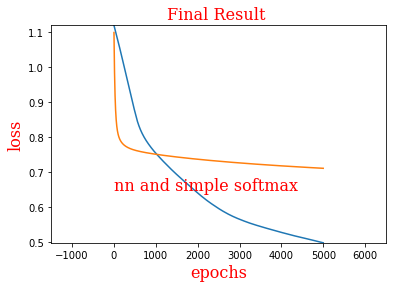

In [20]:

# good values itr = 100000 ,learing_rate = 0.0009

hidden1_size, hidden2_size = 15, 9
deep_loss_list =[]
file_name = "comb.csv"



# one_hot = tf.one_hot(category_indices, unique_category_count) #tensorflow way

all_data_list = ["VX", "VY", "Range_Front","Range_Right","Range_Left","State"]  # define columns to read  from csv TODO add left
feature_list = ["VX", "VY", "Range_Front", "Range_Right", "Range_Left"]
predict_list = ["State"]

df_data = pd.read_csv(file_name, usecols=all_data_list)  # read the collums from the defind col_list
df_data = df_data.sample(frac=1) # random the rows
one_hot_state = pd.get_dummies(df_data["State"])  # transform the data to be predicted to one hot
state = one_hot_state.to_numpy()  # make a numpy array of states
feature = df_data[feature_list]


# np.random.shuffle(data)
# np.random.shuffle(state)

print(state)

#state = np.random.shuffle(state)

(train_data, test_data) = split_train_test(feature)
(train_states,test_states) = split_train_test(state)

# front_arr = np.array([front]) if i wont ro predict by one line only need to convert it to a 2d array

labels_amount =  len(state[0]) # the amount of labels , to be predicted
features_amount = len(feature_list) # The amount of data that the prediction is going to be made on (raw data)
learing_rate = 1e-4
#AdamOptimizer


x = tf.placeholder(tf.float32, (None, features_amount))
y_ = tf.placeholder(tf.float32, (None, labels_amount))
W1 = tf.Variable(tf.truncated_normal([features_amount, hidden1_size], stddev=0.1))
b1 = tf.Variable(tf.constant(0.1, shape=[hidden1_size]))
z1 = tf.nn.relu(tf.matmul(x,W1)+b1)
W2 = tf.Variable(tf.truncated_normal([hidden1_size, hidden2_size], stddev=0.1))
b2 = tf.Variable(tf.constant(0.1, shape=[hidden2_size]))
z2 = tf.nn.relu(tf.matmul(z1,W2)+b2)
W3 = tf.Variable(tf.truncated_normal([hidden2_size, labels_amount], stddev=0.1))
b3 = tf.Variable(tf.constant(0.1, shape=[labels_amount]))
y = tf.nn.softmax(tf.matmul(z2, W3) + b3)
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
z = tf.matmul(z2, W3) + b3
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(y_, z))

#Best result Iteration: 899900 loss: 0.020082667 accuracy is : 0.971564

# W = tf.Variable(tf.zeros((features_amount, labels_amount)))
# b = tf.Variable(tf.zeros((labels_amount)))  # TODO change it to tf.random.uniform
# y = tf.nn.softmax(tf.matmul(x, W) + b)

#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=x)) #TODO try this

train_step = tf.train.AdamOptimizer(learing_rate).minimize(loss)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)



def show_progress(i):
    print('Iteration:', i, ' loss:',cross_entropy.eval(session=sess, feed_dict={x: train_data, y_: train_states}))


for i in range(5000):# change this to 900000 for the best result 
    curr_loss = loss.eval(session=sess, feed_dict={x: train_data, y_: train_states})
    deep_loss_list.append(curr_loss)
    sess.run(train_step, feed_dict={x: train_data, y_: train_states})  # BGD
    if i %100 ==0 :
        show_progress(i)


correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("accuracy is :",sess.run(accuracy, feed_dict={x: test_data, y_: test_states}))

font = {'family': 'serif',
        'color':  'red',
        'weight': 'normal',
        'size': 16,
        }
plt.title('Final Result ', fontdict=font)
plt.text(2, 0.65, r'nn and simple softmax', fontdict=font)
plt.xlabel('epochs', fontdict=font)
plt.ylabel('loss', fontdict=font)
x_axis = np.arange(0, len(loss_list),1)
deep_x_axis = np.arange(0, len(deep_loss_list),1)
plt.margins(x=0.3, y=0.0)   # Values in (-0.5, 0.0) zooms in to center
plt.plot(deep_x_axis, deep_loss_list,x_axis,loss_list)
plt.show()



#Cannot feed value of shape (2175,) for Tensor 'Placeholder:0', which has shape '(?, 3)'

# Save the weights 

In [22]:
#assert False# This stops 'Run all' at this cell by causing an error
filename = "deep_drone_weights.tf"
saver = tf.train.Saver()
saver.save(sess, filename)

'deep_drone_weights.tf'

#Summary 

The nn works better even with the same number of epochs 
from 10,000 and beyond in my case.
Also, Adam Optimizer dramatically increased the learning speed.
one more thing I learned is it's very important to use softmax_cross_entropy_with_logits_v2 instead of the croos_entropy because I had a numerical issue with cross_entropy.

Iteration: 899900  loss: 0.020082667
accuracy is : 0.971564

The best accuracy I achieved is: 0.971564 witch is not bad in my opinion. 
 

